In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from helpers import *

# Data prep

Läs in fil

In [3]:
df = pd.read_csv('../indata/ODB_TSV/ODB-utbildningsnivå, ålder, tid och kön 2015-2017.txt', sep='\t', header=1)

Specificera indexering

In [4]:
df = df.set_index(['område', 'utbildningsnivå'])

Vänd ner samtliga kolumner i en kolumn

In [5]:
df = pd.DataFrame(df.stack())

Lyft ut index till kolumner igen

In [6]:
df = df.reset_index()

Sätt beskrivande kolumnnamn

In [7]:
df = df.rename(columns={'level_2': 'ageyeargender', 0: 'value'})

Splitta områdesnamn till endast baskod

In [8]:
df['område'] = df['område'].str.split(' ', 1, expand = True)
df = df.rename(columns={'område': 'BASKOD2010'})
df['BASKOD2010'] = df['BASKOD2010'].astype(str).astype(int)

Splitta ut `ageyeargender` till fyra separata kolumner

In [9]:
df['agegroup'], df['kasta'], df['year'], df['gender'] = df['ageyeargender'].str.split(' ').str

Kasta kolumner som inte längre är relevanta

In [10]:
df = df.drop('kasta', 1)
df = df.drop('ageyeargender', 1)

Slå samman åldersgrupper till en `25-64` grupp.

In [11]:
df = df[df['agegroup'] != '20-24']

Byt namn på `gender` kolumnen för att följa konventionen i övriga notebooks.

In [12]:
df = df.rename(columns={'gender':'Kön'})

Sätt `Kön` till en pandas category

In [13]:
df['Kön'] = df['Kön'].astype('category')
df['Kön'].cat.categories = ['female', 'male']

In [14]:
df['utbildningsnivå'].unique().tolist()

# df['utbildningsnivå'].unique()

['Förgymnasial',
 'Gymnasial',
 'Eftergymnasial < 3 år',
 'Eftergymnasial 3- år',
 'Uppgift saknas']

Specificera ordningen på kolumnerna

In [15]:
df = df[['BASKOD2010', 'utbildningsnivå', 'agegroup', 'year', 'Kön', 'value']]

Byt om `BASKOD2010` till entity-namnet

In [16]:
# df.columns[:-2]
kolumneratthakvar = list(df.columns[:-2])
kolumnerattflytta = list(df.columns[-2:])

kolumneratthakvar, kolumnerattflytta
# print(kolumneratthakvar, kolumnerattflytta, kolumneratthakvar.insert(-1, kolumnerattflytta))
kolumneratthakvar[-2:-2] = kolumnerattflytta
# df.columns[-2:]
# df.columns
list(df.columns), kolumneratthakvar

(['BASKOD2010', 'utbildningsnivå', 'agegroup', 'year', 'Kön', 'value'],
 ['BASKOD2010', 'utbildningsnivå', 'Kön', 'value', 'agegroup', 'year'])

In [17]:
df = baskod2010tobasomrade(df)

Index(['utbildningsnivå', 'agegroup', 'year', 'Kön', 'value', 'basomrade'], dtype='object')


Specificera indexering

In [18]:
df = df.set_index(['basomrade'])

In [19]:
df = df.groupby(['basomrade', 'year', 'utbildningsnivå', 'Kön']).sum().reset_index()

# Antal

Exportera

In [20]:
concept_key = {
    'Eftergymnasial 3- år': 'higher_education_min_3_years_aged_25_64',
    'Eftergymnasial < 3 år': 'higher_education_max_3_years_aged_25_64',
    'Förgymnasial': 'pre_secondary_school_aged_25_64',
    'Gymnasial': 'secondary_school_aged_25_64',
    'Uppgift saknas': 'missing_data'
}

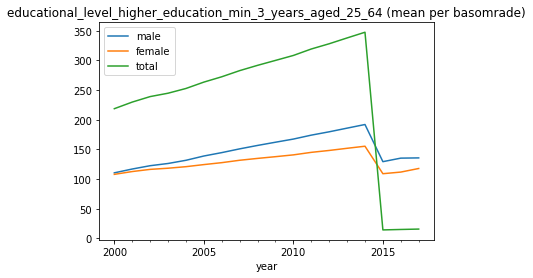

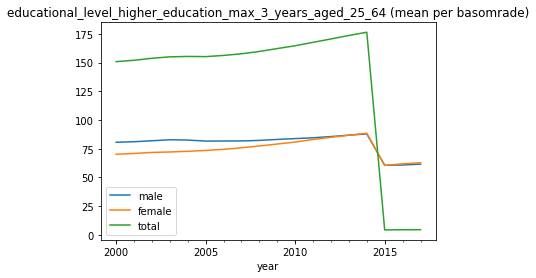

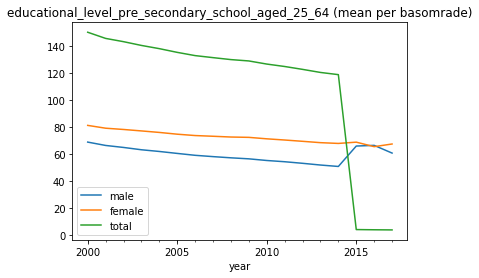

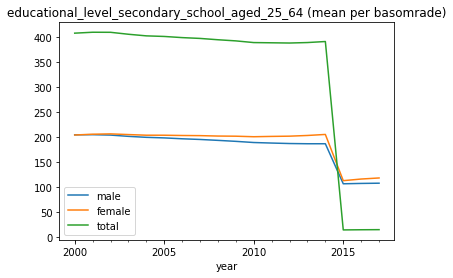

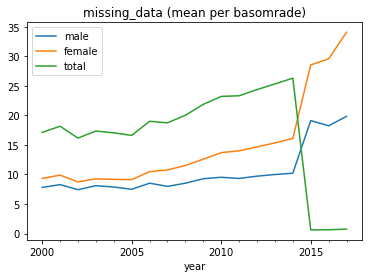

In [21]:
for i in concept_key:
    concept = 'educational_level_{level}'.format(level=concept_key[i]) if i != 'Uppgift saknas' else concept_key[i]
    level = df[df['utbildningsnivå'] == i]
    male, female = byGender(concept, level)
    plotcombined(male, 'male', concept)
    plotcombined(female, 'female')
    level = level.groupby(['basomrade', 'year']).sum().reset_index()
    combined = appendNewDatapoints(concept, level)
    plotcombined(combined, 'total', title=concept) 
    plt.show()
    
    


# Andel högutbildade

In [22]:
concept = 'post_secondary_education_min_3_years_aged_25_64'

### Andel per kön

In [23]:
bygender = df.copy()

Vi är bara intresserade av andel högutbildade

In [24]:
bygender = bygender[bygender['utbildningsnivå'].isin(['Eftergymnasial 3- år'])]

In [25]:
bygender = bygender.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()
bygender = bygender[['basomrade', 'year', 'Kön', 'value']]

In [26]:
total = df.groupby(['basomrade', 'year', 'Kön']).sum().add_prefix('total_').reset_index()

bygender = pd.merge(bygender, total)

In [27]:
bygender['rate'] = bygender['value'] / bygender['total_value']
bygender = bygender[['basomrade', 'year', 'rate', 'Kön']]
bygender = bygender.rename(columns={'rate': 'value'})

Exportera

In [47]:
female, male = byGender(concept, bygender)

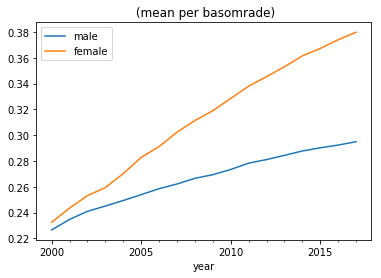

In [48]:
plotcombined(male, 'male', concept)
plotcombined(female, 'female')

### Andel totalt

In [49]:
total = df.groupby(['basomrade', 'year']).sum().add_prefix('total_').reset_index()
rate = df

In [50]:
rate = rate[rate['utbildningsnivå'].isin(['Eftergymnasial 3- år'])]

In [51]:
rate = rate.groupby(['basomrade', 'year']).sum().reset_index()

In [52]:
rate = pd.merge(total, rate)

In [53]:
rate['rate'] = rate['value'] / rate['total_value']

In [54]:
rate = rate[['basomrade', 'year', 'rate']]
rate = rate.rename(columns={'rate': 'value'})

In [55]:
combined = appendNewDatapoints(concept, rate)

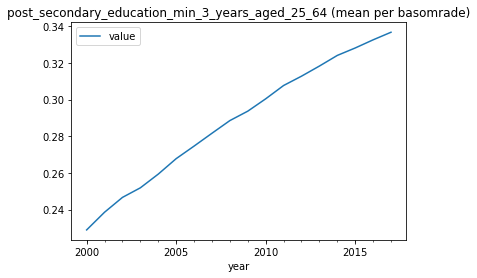

In [56]:
plotcombined(combined, title=concept)